In [1]:
from unittest.mock import inplace

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import joblib

from src.hpo.hpo_pipeline.data_loader import reduce_mem_usage
from src.eval.evaluation.style import apply_shap_style, save_plot, SHAP_RED, SHAP_BLUE, SHAP_GRAY
from src.eval.evaluation.loader import load_test_data_v2
from src.features.scaler.Asinh1Scaler import StaticAsinh1Scaler

apply_shap_style()


In [2]:
SPLITS_PATH = "/Users/robin/PycharmProjects/Masterarbeit/data/parquet/features/asinh1-reg/splits"

TRAIN_FILE = f"{SPLITS_PATH}/train.parquet"
VAL_FILE = f"{SPLITS_PATH}/val_purged.parquet"
TEST_FILE = f"{SPLITS_PATH}/test_purged.parquet"

SCALER_PATH = "/Users/robin/PycharmProjects/Masterarbeit/data/parquet/features/asinh1-reg/scaler/scaler.joblib"

COLS_TO_READ = ["delivery_start", "snapshot_times", "label_5min", "orderbook_depth_ask", "orderbook_depth_bid",
                "bid_ask_spread"]

In [3]:
#load data

from src.eval.evaluation.loader import load_test_data_v2

train_df_X, train_df_y = load_test_data_v2(
    TRAIN_FILE,
    target_col="label_5min",
    sample_minutes=5,
    keep_id_cols=True,
    min_ttd_minutes=0,
    max_ttd_minutes=300
)
train_df = pd.concat([train_df_X, train_df_y], axis=1)

cols_to_drop = []
train_df.drop(columns=cols_to_drop, inplace=True)

val_df_X, val_df_y = load_test_data_v2(
    VAL_FILE,
    target_col="label_5min",
    sample_minutes=5,
    keep_id_cols=True,
    min_ttd_minutes=0,
    max_ttd_minutes=300
)
val_df = pd.concat([val_df_X, val_df_y], axis=1)
val_df.drop(columns=cols_to_drop, inplace=True)

test_df_X, test_df_y = load_test_data_v2(
    TEST_FILE,
    target_col="label_5min",
    sample_minutes=5,
    keep_id_cols=True,
    min_ttd_minutes=0,
    max_ttd_minutes=300
)
test_df = pd.concat([test_df_X, test_df_y], axis=1)
test_df.drop(columns=cols_to_drop, inplace=True)

Memory usage of dataframe is 4702.56 MB
Memory usage after optimization is: 4558.60 MB
Decreased by 3.1%
Downsampling (Relativ 5min): Von 12,579,054 auf 474,911 Zeilen reduziert.
Clipping TTD window to range: 0 - 300 minutes
Rows to be clipped based on TTD min: 0 / 474911 (0.00%)
Rows to be clipped based on TTD max: 0 / 474911 (0.00%)
Data shape after clipping TTD window: (474911, 80)
Memory usage of dataframe is 1496.47 MB
Memory usage after optimization is: 1450.66 MB
Decreased by 3.1%
Downsampling (Relativ 5min): Von 4,002,956 auf 142,153 Zeilen reduziert.
Clipping TTD window to range: 0 - 300 minutes
Rows to be clipped based on TTD min: 0 / 142153 (0.00%)
Rows to be clipped based on TTD max: 0 / 142153 (0.00%)
Data shape after clipping TTD window: (142153, 80)
Memory usage of dataframe is 747.76 MB
Memory usage after optimization is: 724.87 MB
Decreased by 3.1%
Downsampling (Relativ 5min): Von 2,000,203 auf 71,628 Zeilen reduziert.
Clipping TTD window to range: 0 - 300 minutes
Rows

In [6]:
# inverse scaling
scaler: StaticAsinh1Scaler = joblib.load(SCALER_PATH)
print("Scaler loaded successfully")

# add scaler ttd col
train_df[scaler.ttd_col] = (train_df["delivery_start"] - train_df["snapshot_times"]).dt.total_seconds() / 60
val_df[scaler.ttd_col] = (val_df["delivery_start"] - val_df["snapshot_times"]).dt.total_seconds() / 60
test_df[scaler.ttd_col] = (test_df["delivery_start"] - test_df["snapshot_times"]).dt.total_seconds() / 60
print("TTD column added to all splits")

# inverse transform all data together to ensure consistency in feature engineering and plotting
train_df_raw = scaler.inverse_transform(train_df)
print("Inverse transformation completed for training split")
val_df_raw = scaler.inverse_transform(val_df)
print("Inverse transformation completed for validation split")
test_df_raw = scaler.inverse_transform(test_df)
print("Inverse transformation completed for testing split")

print("Inverse transformation completed for all splits")

Scaler loaded successfully
TTD column added to all splits


Inverse transforming features with Asinh1Scaler: 100%|██████████| 61/61 [00:00<00:00, 248.61it/s]


Inverse transformation completed for training split


Inverse transforming features with Asinh1Scaler: 100%|██████████| 61/61 [00:00<00:00, 670.25it/s]


Inverse transformation completed for validation split


Inverse transforming features with Asinh1Scaler: 100%|██████████| 61/61 [00:00<00:00, 1177.26it/s]

Inverse transformation completed for testing split
Inverse transformation completed for all splits


In [4]:
import pandas as pd
import numpy as np


def get_split_stats(df, split_name):
    num_samples = len(df)

    # Basis-Statistiken
    label_mean = df["label_5min"].mean()
    label_std = df["label_5min"].std()

    # Höhere Momente (Wichtig für Risk-Assessment)
    # .kurtosis() in Pandas berechnet "Excess Kurtosis" (Normalverteilung = 0)
    label_kurt = df["label_5min"].kurtosis()
    label_skew = df["label_5min"].skew()

    return {
        "split": split_name,
        "Start Date": df["snapshot_times"].min(),
        "End Date": df["snapshot_times"].max(),
        "First Product": df["delivery_start"].min(),
        "Last Product": df["delivery_start"].max(),
        "Number of Observations": num_samples,
        "Number of Products": df["delivery_start"].nunique(),
        "Mean": label_mean,
        "Std Dev": label_std,
        "Skewness": label_skew,  # Neu: Schiefe
        "Kurtosis": label_kurt,  # Neu: Wölbung
        "5th Percentile": np.percentile(df["label_5min"], 5),
        "25th Percentile": np.percentile(df["label_5min"], 25),
        "50th Percentile": np.percentile(df["label_5min"], 50),
        "75th Percentile": np.percentile(df["label_5min"], 75),
        "95th Percentile": np.percentile(df["label_5min"], 95),
    }


# --- BERECHNUNG ---

all_samples = len(train_df) + len(test_df) + len(val_df)

# Stats berechnen
train_stats = get_split_stats(train_df, f"Training Set ({len(train_df) / all_samples:.1%})")
val_stats = get_split_stats(val_df, f"Validation Set ({len(val_df) / all_samples:.1%})")
test_stats = get_split_stats(test_df, f"Test Set ({len(test_df) / all_samples:.1%})")
sum_stats = get_split_stats(pd.concat([train_df, val_df, test_df]), "Summary (Total)")

# DataFrame bauen
stats_df = pd.DataFrame([train_stats, val_stats, test_stats, sum_stats]).set_index("split").T

# Optional: Formatierung für schönere Anzeige (Runden)
# Wir runden numerische Spalten, lassen Datumsangaben aber in Ruhe
pd.options.display.float_format = '{:,.4f}'.format

stats_df

split,Training Set (67.7%),Validation Set (21.5%),Test Set (10.8%),Summary (Total)
Start Date,2023-02-28 19:30:00,2024-04-11 14:50:10,2024-08-04 09:50:10,2023-02-28 19:30:00
End Date,2024-04-11 14:50:00,2024-08-04 09:50:00,2024-09-30 20:50:00,2024-09-30 20:50:00
First Product,2023-03-01 00:00:00,2024-04-11 17:00:00,2024-08-04 12:00:00,2023-03-01 00:00:00
Last Product,2024-04-11 15:00:00,2024-08-04 10:00:00,2024-09-30 21:00:00,2024-09-30 21:00:00
Number of Observations,12579054,4002956,2000203,18582213
Number of Products,9644,2754,1378,13776
Mean,0.0006,0.0058,-0.0136,0.0002
Std Dev,0.9728,1.0798,1.0406,0.9945
Skewness,0.0314,0.0420,0.0173,0.0328
Kurtosis,0.6749,1.0939,0.8491,0.8376


/var/folders/_g/t9jm9x4n7v313q5_zspldllr0000gn/T/ipykernel_6852/1419805861.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat_rolled = daily_feat.reindex(daily_idx).fillna(method='ffill').rolling(window=rolling_days,


✅ Grafik gespeichert in: figures/regime_context


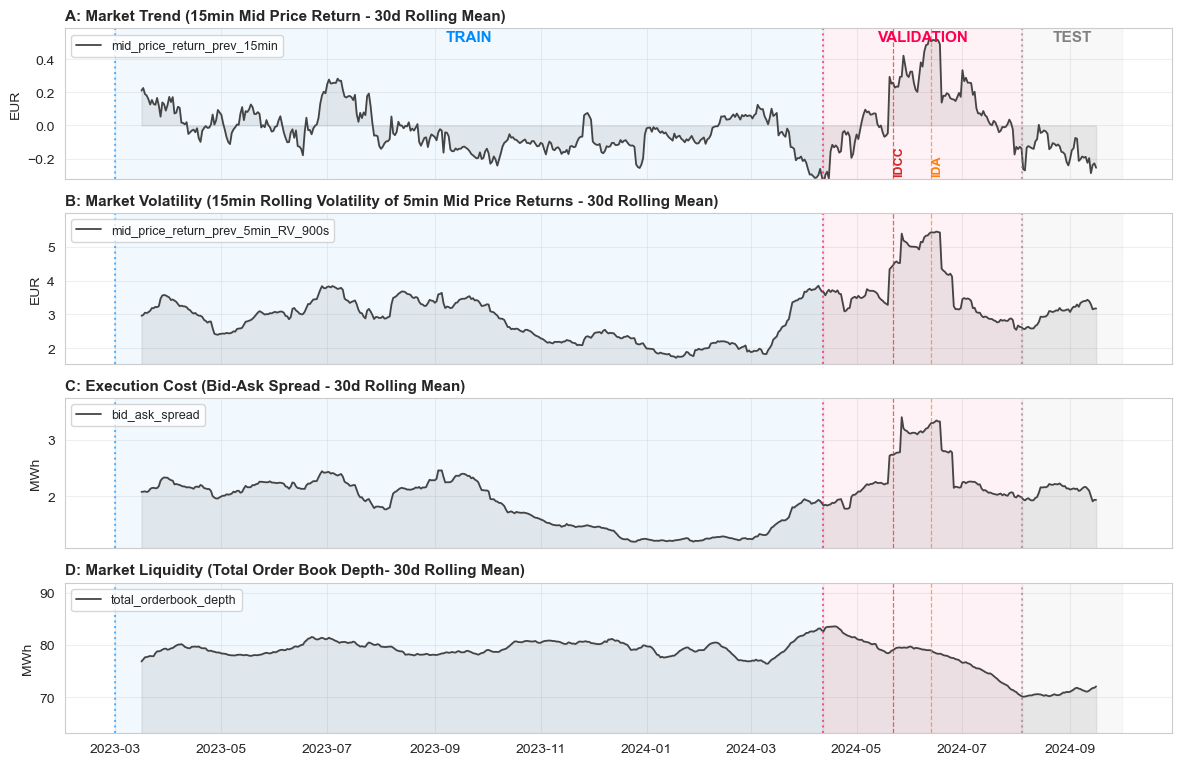

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def plot_regime_impact(
        rolling_days=7,
        save_name=None,
        # Parameter für X_test Features
        X_test: pd.DataFrame = None,
        feature_cols: list = None,
        feature_titles: list = None,
        feature_y_labels: list = None,
        # NEU: Parameter für Datensatz-Splits
        split_dates: dict = None
):
    """
    Visualisierung von Equity, Daily PnL und Markt-Regimes.
    Features aus X_test werden über 'snapshot_times' auf Tagesbasis aggregiert
    und mit einem daily rolling window geglättet.
    Individuelle Thresholds pro Modell werden unterstützt.

    split_dates erwartet ein Dict im Format:
    {'Train': ('start_datum', 'end_datum'), 'Val': (...), 'Test': (...)}
    """

    events = {
        "IDCC": (pd.Timestamp("2024-05-22"), "#d62728"),
        "IDA": (pd.Timestamp("2024-06-13"), "#ff7f0e")
    }

    full_time_idx = pd.date_range(
        start=X_test['delivery_start'].min(),
        end=X_test['delivery_start'].max(),
        freq='h'
    )
    # Referenz-Index für tägliche Daten
    daily_idx = pd.date_range(full_time_idx.min().floor('D'), full_time_idx.max().floor('D'), freq='D')

    # --- 3. SUBPLOTS SETUP ---
    num_features = len(feature_cols) if feature_cols is not None else 0

    fig, axes = plt.subplots(num_features, 1, figsize=(12, 2 * num_features), sharex=True)

    # Wenn nur ein Subplot da wäre (was bei 2 + x eigentlich nicht passiert, aber sicherheitshalber)
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    # --- NEUE PANELS: DAILY ROLLING FEATURES ---
    if num_features > 0 and X_test is not None:
        # Sicherstellen, dass snapshot_times datetime ist
        X_tmp = X_test.copy()
        X_tmp['snapshot_day'] = pd.to_datetime(X_tmp['snapshot_times']).dt.floor('D')

        for i, col in enumerate(feature_cols):
            cur_ax = axes[i]

            # 1. Daily Aggregation (Mittelwert pro Tag)
            daily_feat = X_tmp.groupby('snapshot_day')[col].mean()

            # 2. Daily Rolling
            feat_rolled = daily_feat.reindex(daily_idx).fillna(method='ffill').rolling(window=rolling_days,
                                                                                       center=True).mean()

            ylim_max = feat_rolled.max() * 1.1
            ylim_min = feat_rolled.min() * 0.9

            # Plot
            cur_ax.plot(feat_rolled.index, feat_rolled, color='#444444', linewidth=1.3, label=col)
            cur_ax.fill_between(feat_rolled.index, feat_rolled, color='gray', alpha=0.15)

            # Labels
            title = feature_titles[i] if (feature_titles and i < len(feature_titles)) else f"Feature: {col}"
            y_lab = feature_y_labels[i] if (feature_y_labels and i < len(feature_y_labels)) else "Daily Avg (Smoothed)"

            cur_ax.set_ylim(ylim_min, ylim_max)

            cur_ax.set_title(title, fontsize=11, fontweight='bold', loc='left')
            cur_ax.set_ylabel(y_lab)
            cur_ax.grid(True, alpha=0.3)
            cur_ax.legend(loc='upper left', fontsize=9, frameon=True)

    # --- FORMATIERUNG & EVENTS ---
    for ax in axes:
        min_time, max_time = ax.get_xlim()

        # --- NEU: SPLITS KENNZEICHNEN ---
        if split_dates:
            split_colors = {'Train': SHAP_BLUE, 'Validation': SHAP_RED, 'Test': 'gray'}

            for split_name, (start_dt, end_dt) in split_dates.items():
                start_ts = pd.to_datetime(start_dt)
                end_ts = pd.to_datetime(end_dt)

                start_num = mdates.date2num(start_ts)
                end_num = mdates.date2num(end_ts)

                color = split_colors.get(split_name, 'gray')  # Fallback auf Grau für andere Namen

                # Prüfen, ob der Split im aktuellen Sichtbereich des Plots liegt
                if start_num <= max_time and end_num >= min_time:
                    # Leichte Hintergrundschattierung
                    ax.axvspan(start_ts, end_ts, color=color, alpha=0.05)

                    # Gepunktete Trennlinie am Anfang des Splits
                    if start_num >= min_time:
                        ax.axvline(start_ts, color=color, linestyle=':', lw=1.5, alpha=0.6)

                    # Textbeschriftung nur im allerersten Subplot ganz oben setzen
                    if ax == axes[0]:
                        # Berechne die visuelle Mitte des Splits für die Textplatzierung
                        visible_start = max(start_num, min_time)
                        visible_end = min(end_num, max_time)
                        mid_num = (visible_start + visible_end) / 2

                        ax.text(mdates.num2date(mid_num), ax.get_ylim()[1] * 0.98, split_name.upper(),
                                ha='center', va='top', fontsize=11, fontweight='bold', color=color, alpha=1)

        # --- EVENTS (Original) ---
        for event_name, event_data in events.items():
            # min_time und max_time müssen neu geladen werden, falls axvspan die Limits minimal verschoben hat
            min_t, max_t = ax.get_xlim()
            event_num = mdates.date2num(event_data[0])

            if min_t <= event_num <= max_t:
                ax.axvline(event_data[0], color=event_data[1], linestyle='--', alpha=0.7, lw=0.9)

                if ax == axes[0]:
                    ax.text(event_data[0], ax.get_ylim()[0] * 0.95, event_name, color=event_data[1],
                            fontsize=9, fontweight='bold', rotation=90, va='bottom', ha='left')

    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # wenn mehr als 2 monate im plot sind, dann monatliche ticks, sonst wöchentliche
    if (full_time_idx.max() - full_time_idx.min()).days > 60:
        axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    else:
        axes[-1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

    plt.tight_layout(rect=[0, 0.03, 1, 1])
    if save_name:
        save_plot(fig, save_name)  # Auskommentiert für Standalone-Test
    plt.show()


my_splits = {
    'Train': (train_df["snapshot_times"].min(), train_df["snapshot_times"].max()),
    'Validation': (val_df["snapshot_times"].min(), val_df["snapshot_times"].max()),
    'Test': (test_df["snapshot_times"].min(), test_df["snapshot_times"].max()),
}

df_all_raw = pd.concat([train_df_raw, val_df_raw, test_df_raw])

df_all_raw["total_orderbook_depth"] = df_all_raw["orderbook_depth_ask"] + df_all_raw["orderbook_depth_bid"]
df_all_raw["mean_orderbook_depth"] = (df_all_raw["orderbook_depth_ask"] + df_all_raw["orderbook_depth_bid"]) / 2

plot_regime_impact(
    rolling_days=30,
    split_dates=my_splits,
    save_name="regime_context",
    X_test=df_all_raw,
    feature_cols=["mid_price_return_prev_15min", "mid_price_return_prev_5min_RV_900s", "bid_ask_spread",
                  "total_orderbook_depth"],
    feature_titles=[f"A: Market Trend (15min Mid Price Return - {30}d Rolling Mean)",
                    f"B: Market Volatility (15min Rolling Volatility of 5min Mid Price Returns - {30}d Rolling Mean)",
                    f"C: Execution Cost (Bid-Ask Spread - {30}d Rolling Mean)",
                    f"D: Market Liquidity (Total Order Book Depth- {30}d Rolling Mean)"],
    feature_y_labels=['EUR', "EUR", "MWh", "MWh"],
)